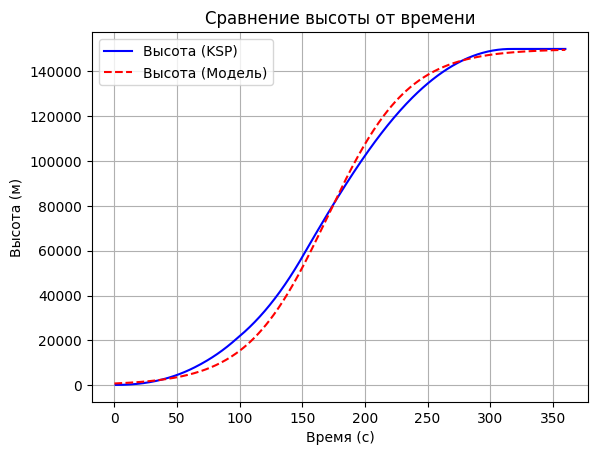

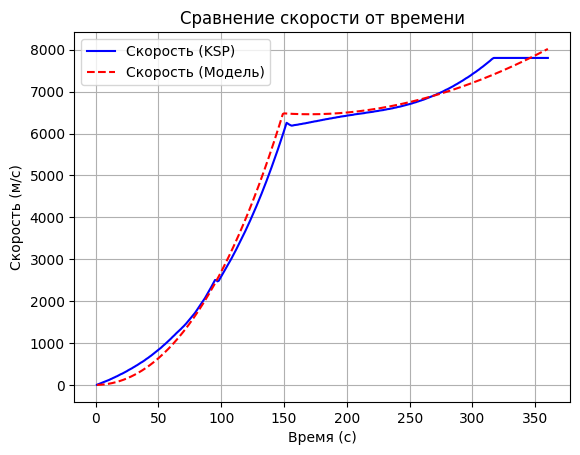

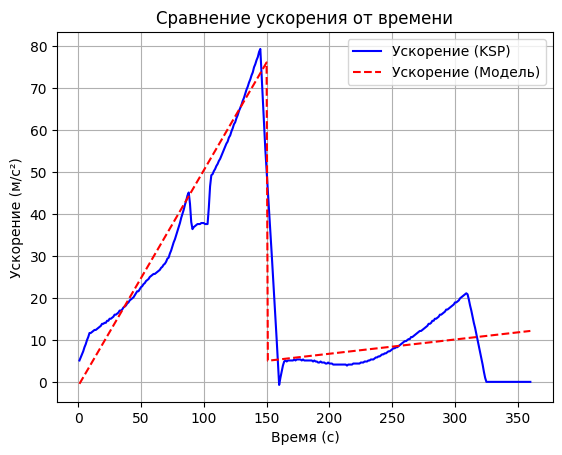

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


# Чтение данных из файла
df = pd.read_csv('graph/Data.csv', sep=';')

# Извлечение данных из таблицы
Time = df['Time']
Velocity = df['Velocity']
Altitude = df['AltitudeFromTerrain']

# Ограничиваем данные до 360 секунд
Time_filtered = Time[Time <= 360]
Velocity_filtered = Velocity[:len(Time_filtered)]
Altitude_filtered = Altitude[:len(Time_filtered)]

# Модифицированная скорость (делим на 1.1)
Velocity_modified = Velocity_filtered / 1.1

# Вычисление ускорения от скорости
Acceleration = np.diff(Velocity_modified) / np.diff(Time_filtered)
Acceleration = np.insert(Acceleration, 0, 0)  # Добавляем 0 для совместимости

# Для сглаживания ускорения применяем скользящее среднее
Acceleration_smooth = np.convolve(Acceleration, np.ones(15) / 15, mode='same')

# Математическая модель для скорости и ускорения
G = 6.6743 * 10**(-11)
Mz = 5.974 * 10**24
m0 = 571585
n1 = 1900
n2 = 20
u = 3000
fuel1 = 500265
fuel2 = 20830
msuh1 = 38247
msuh2 = 2243
m1 = msuh1 + fuel1
m2 = msuh2 + fuel2
Mgraph = []
V = []
v0 = 0

# Функция для расчёта тяготы
def Ftyag(m):
    return G * ((Mz * m) / (6400000)**2)

# Моделирование до 360 секунд
for t in range(1, 150):  # Период с ускорением n1
    m = m0 - n1 * t
    Mgraph.append(m)
    v1 = (v0 - u * np.log(m / m0) - (G * Mz * np.log(m / m0)) / (6400000**2))
    d = v1 / 1000 * 4
    V.append(d)
    v0 = v1
    if t >= 360:
        break

m0 -= fuel1 + msuh1

for t in range(150, 1095):  # Период с ускорением n2
    m = m0 - n2 * t
    Mgraph.append(m)
    v1 = (v0 - u * np.log(m / m0) - (G * Mz * np.log(m / m0)) / (6400000**2))
    d = v1 / 1000 * 4
    v1 *= 0.9976
    V.append(d)
    v0 = v1
    if t >= 360:
        break

m0 -= fuel2 + msuh2

# Рассчитаем ускорение на основе модели
Acc = [0] * len(V)
T = np.arange(1, len(V) + 1)

for t in range(len(V)):
    if t < 150:
        Acc[t] = ((u * n1 * t - Ftyag(m1 - (4 * 1120 + 1818) * (t + 1))) / m1) / 75
    else:
        Acc[t] = ((u * n2 * t - Ftyag(m2 - 2281 * 2 * (t + 1))) / m2) / 480
    if t >= 360:
        break

# Умножаем скорость на 11.8 и ускорение на 3.6
V = np.array(V) * 11.8
Acc = np.array(Acc) * 3.6

# Модель высоты с S-образной кривой
T_alt = np.arange(0, 361, 1)  # Время для высоты
H = 150000 / (1 + np.exp(-0.031 * (T_alt - 170)))  # S-образная кривая

# Построение графиков
plt.plot(Time_filtered, Altitude_filtered, label="Высота (KSP)", color="blue")
plt.plot(T_alt, H, label="Высота (Модель)", color="red", linestyle='--')

plt.title("Сравнение высоты от времени")
plt.xlabel("Время (с)")
plt.ylabel("Высота (м)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(Time_filtered, Velocity_filtered, label="Скорость (KSP)", color="blue")
plt.plot(T[:len(V)], V[:len(V)], label="Скорость (Модель)", color="red", linestyle='--')

plt.title("Сравнение скорости от времени")
plt.xlabel("Время (с)")
plt.ylabel("Скорость (м/с)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(Time_filtered, Acceleration_smooth, label="Ускорение (KSP)", color="blue")
plt.plot(T[:len(V)], Acc[:len(V)], label="Ускорение (Модель)", color="red", linestyle='--')

plt.title("Сравнение ускорения от времени")
plt.xlabel("Время (с)")
plt.ylabel("Ускорение (м/с²)")
plt.legend()
plt.grid(True)
plt.show()
